In [5]:
%run "..\..\Startup_py3.py"
sys.path.append(r"..\..")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

15740


In [6]:
import cv2
from tqdm import tqdm

In [7]:
data_folder = r'\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6'

folders, fovs = ia.io_tools.data.get_folders(data_folder)

Get Folder Names: (ia.get_img_info.get_folders)
- Number of folders: 12
- Number of field of views: 339


In [8]:
correction_folder = r'\\10.245.74.158\Chromatin_NAS_0\Corrections\20210621-Corrections_lumencor_from_60_to_50'

segmentation_save_folder = os.path.join(data_folder, 'Segmentation')
if not os.path.exists(segmentation_save_folder):
    os.makedirs(segmentation_save_folder)
from cellpose import models

from ImageAnalysis3.segmentation_tools.cell import Align_Segmentation
reload(ia.segmentation_tools.cell)

# transpose with microscope
microscope_file = r'\\mendel\pu_documents\Merfish_analysis\Merfish_Analysis_Scripts\merlin_parameters\microscope\storm6_microscope.json'
microscope_params = Align_Segmentation._read_microscope_json(microscope_file)
microscope_params

{'flip_horizontal': False,
 'flip_vertical': True,
 'transpose': True,
 'microns_per_pixel': 0.108}

In [9]:
sys.path.append(r"..\..\MERlin")

import merlin
from merlin.util import watershed
from scipy import ndimage
from skimage import morphology
from skimage import segmentation

watershed_folder = os.path.join(segmentation_save_folder, 'watershed')
if not os.path.exists(watershed_folder):
    print(watershed_folder)
    os.makedirs(watershed_folder)

\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed


# Part 2: watershed

In [15]:
for _fov_id, _fov_name in enumerate(fovs):
    _save_id = _fov_id 
    seg_save_file = os.path.join(segmentation_save_folder, f'segmentation_label_{_save_id}.npy')
    watershed_save_file = os.path.join(watershed_folder, f'segmentation_label_{_save_id}.npy')
    if os.path.exists(watershed_save_file):
        print(f"{watershed_save_file} already exists, skip")
        continue
    
    ref_image_file = os.path.join(folders[0], _fov_name)
    polyt_image_file = os.path.join(folders[-1], _fov_name)
    print(f"reference image: {ref_image_file}")
    print(f"PolyT and DAPI image: {polyt_image_file}")
    # load reference DAPI
    _ref_cls = ia.classes.preprocess.DaxProcesser(ref_image_file, 
                                                  CorrectionFolder=correction_folder, 
                                                  DriftChannel=488, DapiChannel=405)
    _ref_cls._load_image(sel_channels=[488])
    _ref_cls._corr_illumination()
    _ref_im = _ref_cls.im_488
    
    # load polyT and DAPI
    _cls = ia.classes.preprocess.DaxProcesser(polyt_image_file, 
                                              CorrectionFolder=correction_folder, 
                                              DriftChannel=488, DapiChannel=405)
    _cls._load_image(sel_channels=[750,488,405])
    _cls._corr_illumination()
    _cls.im_750 = _cls.im_750[0::4]
    _cls.im_488 = _cls.im_488[0::4]
    _cls.image_size = np.array(np.shape(_ref_im))
    _cls._calculate_drift(_ref_im)
    _cls._warp_image(correction_channels=[750], corr_chromatic=False)

    polyt_im = Align_Segmentation._correct_image3D_by_microscope_param(_cls.im_750, microscope_params)

    # Load segmentation
    if os.path.isfile(seg_save_file):
        print(f"- directly load seg from: {seg_save_file}")
        corr_labels3d = np.load(seg_save_file)
    else:
        print(f"- seg file: {seg_save_file} has not been generated yet, skip. ")
        continue
        
    # Prepare watershed
    print(f"- run watershed", end=' ')
    _watershed_start = time.time()
    water_input_im = polyt_im
    waterIm, waterMask = watershed.prepare_watershed_images(water_input_im, 1.6)
    waterMask[corr_labels3d > 0] = True
    waterMask = ndimage.binary_dilation(waterMask, structure=morphology.ball(1))
    # watershed
    new_labels = segmentation.watershed(
                    waterIm, corr_labels3d, mask=waterMask,
                    connectivity=np.ones((3, 3, 3)), watershed_line=True)
    print(f"in {time.time()-_watershed_start:.3f}s.")

    # save
    # save this segmentation mask
    print(f"- save to file: {watershed_save_file}")
    np.save(watershed_save_file.split('.npy')[0], new_labels, )
    
    #break

\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_0.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_1.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_2.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_3.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_4.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_5.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_6.npy already exists, skip
\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_7.npy alrea

- run watershed in 77.981s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_13.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_014.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_014.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_014.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.532s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.291s.
- Finished illumination correction in 1.494s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M1

- Loaded images for channels:['750', '488', '405'] in 2.610s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.233s.
-- corrected illumination for channel 488 in 4.422s.
-- corrected illumination for channel 405 in 4.267s.
- Finished illumination correction in 13.032s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -3.619e+01  1.830e+01] in 0.594s.
-- drift 1: [-1.000e-02 -3.610e+01  1.842e+01] in 0.562s.
-- drift 2: [-1.000e-02 -3.614e+01  1.839e+01] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image w

- run watershed in 76.512s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_20.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_021.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_021.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_021.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.062s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.140s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M1

-- corrected illumination for channel 750 in 4.155s.
-- corrected illumination for channel 488 in 4.500s.
-- corrected illumination for channel 405 in 4.406s.
- Finished illumination correction in 13.156s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 2.000e-02 -3.636e+01  2.708e+01] in 0.594s.
-- drift 1: [ 2.000e-02 -3.644e+01  2.716e+01] in 0.640s.
-- drift 2: [ 3.000e-02 -3.648e+01  2.740e+01] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 2.33333333e-02 -3.64266667e+01  2.72133333e+01] for channel: 750
-- finish warpping channel 750 in 16.313s.
-- finish warpping in 16.313s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_24.npy
- run watershed in 73.273s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmen

- Loaded images for channels:['488'] in 1.033s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction in 1.156s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_028.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.578s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.313s.
-- corrected illuminat

-- drift 0: [ 1.000e-02 -3.488e+01  1.530e+01] in 0.547s.
-- drift 1: [  0.   -34.9   15.41] in 0.625s.
-- drift 2: [  0.   -34.92  15.43] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 3.33333333e-03 -3.49000000e+01  1.53800000e+01] for channel: 750
-- finish warpping channel 750 in 16.319s.
-- finish warpping in 16.319s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_31.npy
- run watershed in 92.621s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_31.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_032.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_032.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_samp

- Loaded images for channels:['488'] in 1.046s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.153s.
- Finished illumination correction in 1.228s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_035.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.640s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.235s.
-- corrected illuminat

-- drift 0: [  0.   -35.89   7.01] in 0.625s.
-- drift 1: [-1.000e-02 -3.588e+01  7.300e+00] in 0.594s.
-- drift 2: [ 1.000e-02 -3.571e+01  6.990e+00] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.         -35.82666667   7.1       ] for channel: 750
-- finish warpping channel 750 in 16.358s.
-- finish warpping in 16.358s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_38.npy
- run watershed in 85.018s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_38.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_039.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_039.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_s

-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_042.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.627s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.250s.
-- corrected illumination for channel 488 in 4.537s.
-- corrected illumination for channel 405 in 4.266s.
- Finished illumination correction in 13.178s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[-1.00000000e-02 -3.50733333e+01  1.15133333e+01] for channel: 750
-- finish warpping channel 750 in 16.391s.
-- finish warpping in 16.391s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_45.npy
- run watershed in 97.504s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_45.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_046.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_046.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_046.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.377s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loadi

- Loaded images for channels:['750', '488', '405'] in 2.624s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.219s.
-- corrected illumination for channel 488 in 4.266s.
-- corrected illumination for channel 405 in 4.297s.
- Finished illumination correction in 12.876s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 2.000e-02 -3.696e+01  1.642e+01] in 0.609s.
-- drift 1: [  0.   -36.93  16.45] in 0.547s.
-- drift 2: [ 3.000e-02 -3.703e+01  1.653e+01] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 

- run watershed in 83.072s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_52.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_053.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_053.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_053.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.281s.
- Finished illumination correction in 1.343s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M1

- Loaded images for channels:['750', '488', '405'] in 3.172s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.218s.
-- corrected illumination for channel 488 in 4.375s.
-- corrected illumination for channel 405 in 4.266s.
- Finished illumination correction in 12.984s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -35.29   9.9 ] in 0.594s.
-- drift 1: [-2.000e-02 -3.529e+01  1.002e+01] in 0.578s.
-- drift 2: [ 1.000e-02 -3.528e+01  1.002e+01] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-

- run watershed in 88.985s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_59.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_060.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_060.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_060.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M1

-- corrected illumination for channel 750 in 4.188s.
-- corrected illumination for channel 488 in 4.298s.
-- corrected illumination for channel 405 in 4.265s.
- Finished illumination correction in 12.860s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 2.000e-02 -3.465e+01  1.163e+01] in 0.625s.
-- drift 1: [ 2.000e-02 -3.464e+01  1.154e+01] in 0.609s.
-- drift 2: [ 3.000e-02 -3.482e+01  1.176e+01] in 0.594s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 2.33333333e-02 -3.47033333e+01  1.16433333e+01] for channel: 750
-- finish warpping channel 750 in 16.344s.
-- finish warpping in 16.344s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_63.npy
- run watershed in 77.767s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmen

- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.250s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_067.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.611s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.186s.
-- corrected illuminat

-- drift 0: [-2.000e-02 -3.599e+01  1.968e+01] in 0.640s.
-- drift 1: [ -0.04 -35.98  19.66] in 0.531s.
-- drift 2: [-3.000e-02 -3.582e+01  1.967e+01] in 0.627s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-3.000e-02 -3.593e+01  1.967e+01] for channel: 750
-- finish warpping channel 750 in 16.671s.
-- finish warpping in 16.671s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_70.npy
- run watershed in 78.857s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_70.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_071.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_071.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6

- Loaded images for channels:['488'] in 1.062s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.110s.
- Finished illumination correction in 1.188s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_074.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 4.077s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.270s.
-- corrected illuminat

-- drift 0: [ 3.000e-02 -3.534e+01  1.369e+01] in 0.604s.
-- drift 1: [ 1.000e-02 -3.516e+01  1.371e+01] in 0.594s.
-- drift 2: [  0.04 -35.24  13.68] in 0.594s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 2.66666667e-02 -3.52466667e+01  1.36933333e+01] for channel: 750
-- finish warpping channel 750 in 16.413s.
-- finish warpping in 16.413s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_77.npy
- run watershed in 86.976s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_77.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_078.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_078.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-h

-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_081.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.705s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.375s.
-- corrected illumination for channel 488 in 4.452s.
-- corrected illumination for channel 405 in 4.453s.
- Finished illumination correction in 13.374s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[  0.04       -35.01333333  14.58666667] for channel: 750
-- finish warpping channel 750 in 16.320s.
-- finish warpping in 16.320s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_84.npy
- run watershed in 85.527s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_84.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_085.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_085.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_085.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.953s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumi

- Loaded images for channels:['750', '488', '405'] in 2.718s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.188s.
-- corrected illumination for channel 488 in 4.298s.
-- corrected illumination for channel 405 in 4.397s.
- Finished illumination correction in 12.992s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.4  -34.77  18.91] in 0.594s.
-- drift 1: [  0.22 -34.8   19.08] in 0.547s.
-- drift 2: [  0.41 -34.82  19.11] in 0.595s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.34333333 -34.79666667

- run watershed in 83.386s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_91.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_092.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_092.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_092.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 1.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M1

- Loaded images for channels:['750', '488', '405'] in 2.578s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.235s.
-- corrected illumination for channel 488 in 4.249s.
-- corrected illumination for channel 405 in 4.346s.
- Finished illumination correction in 12.939s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-2.000e-02 -3.643e+01  7.350e+00] in 0.562s.
-- drift 1: [ -0.09 -36.44   7.54] in 0.562s.
-- drift 2: [-3.000e-02 -3.629e+01  7.550e+00] in 0.585s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 

- run watershed in 88.825s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_98.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_099.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_099.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_099.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.033s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.093s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M1

-- corrected illumination for channel 750 in 4.436s.
-- corrected illumination for channel 488 in 4.501s.
-- corrected illumination for channel 405 in 4.611s.
- Finished illumination correction in 13.861s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-3.000e-02 -3.436e+01  1.234e+01] in 0.682s.
-- drift 1: [ -0.04 -34.28  12.4 ] in 0.625s.
-- drift 2: [-1.000e-02 -3.433e+01  1.233e+01] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-2.66666667e-02 -3.43233333e+01  1.23566667e+01] for channel: 750
-- finish warpping channel 750 in 16.427s.
-- finish warpping in 16.427s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_102.npy
- run watershed in 81.948s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\wate

- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_106.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.688s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.218s.
-- corrected illuminat

-- drift 0: [  0.   -34.23  10.15] in 0.625s.
-- drift 1: [-2.000e-02 -3.423e+01  1.023e+01] in 0.547s.
-- drift 2: [-1.000e-02 -3.430e+01  1.024e+01] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.00000000e-02 -3.42533333e+01  1.02066667e+01] for channel: 750
-- finish warpping channel 750 in 16.297s.
-- finish warpping in 16.297s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_109.npy
- run watershed in 98.172s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_109.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_110.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_110.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012

- Loaded images for channels:['488'] in 1.062s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.188s.
- Finished illumination correction in 1.251s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_113.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.562s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.266s.
-- corrected illuminat

-- drift 0: [-2.000e-02 -3.409e+01  8.870e+00] in 0.562s.
-- drift 1: [ -0.05 -34.05   9.09] in 0.594s.
-- drift 2: [-1.00e-02 -3.41e+01  8.99e+00] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-2.66666667e-02 -3.40800000e+01  8.98333333e+00] for channel: 750
-- finish warpping channel 750 in 16.383s.
-- finish warpping in 16.383s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_116.npy
- run watershed in 93.598s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_116.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_117.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_117.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hM

- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.140s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_120.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.617s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.235s.
-- corrected illuminat

-- drift 0: [-2.000e-02 -3.428e+01  9.810e+00] in 0.594s.
-- drift 1: [-3.000e-02 -3.429e+01  9.850e+00] in 0.562s.
-- drift 2: [-2.000e-02 -3.427e+01  9.770e+00] in 0.594s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-2.33333333e-02 -3.42800000e+01  9.81000000e+00] for channel: 750
-- finish warpping channel 750 in 16.321s.
-- finish warpping in 16.321s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_123.npy
- run watershed in 93.050s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_123.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_124.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_124.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

-- corrected illumination for channel 488 in 1.172s.
- Finished illumination correction in 1.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_127.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.593s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.547s.
-- corrected illumination for channel 488 in 4.235s.
-- corrected illumination for channel 405 in 4.219s.
- Finished illumination correction in 13.032s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[-6.66666667e-03 -3.35866667e+01  8.71333333e+00] for channel: 750
-- finish warpping channel 750 in 16.252s.
-- finish warpping in 16.252s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_130.npy
- run watershed in 77.342s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_130.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_131.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_131.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_131.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loa

-- corrected illumination for channel 488 in 1.138s.
- Finished illumination correction in 1.200s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_134.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.516s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.478s.
-- corrected illumination for channel 488 in 4.500s.
-- corrected illumination for channel 405 in 4.390s.
- Finished illumination correction in 13.493s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[-1.66666667e-02 -3.33500000e+01  1.00566667e+01] for channel: 750
-- finish warpping channel 750 in 16.443s.
-- finish warpping in 16.443s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_137.npy
- run watershed in 80.025s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_137.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_138.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_138.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_138.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.064s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loa

-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_141.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.657s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.202s.
-- corrected illumination for channel 488 in 4.318s.
-- corrected illumination for channel 405 in 4.343s.
- Finished illumination correction in 13.034s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[-2.66666667e-02 -3.38633333e+01  8.39333333e+00] for channel: 750
-- finish warpping channel 750 in 16.640s.
-- finish warpping in 16.640s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_144.npy
- run watershed in 94.686s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_144.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_145.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_145.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_145.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loa

- Loaded images for channels:['750', '488', '405'] in 2.640s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.238s.
-- corrected illumination for channel 488 in 4.266s.
-- corrected illumination for channel 405 in 4.343s.
- Finished illumination correction in 12.987s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -3.366e+01  1.049e+01] in 0.547s.
-- drift 1: [-2.000e-02 -3.369e+01  1.069e+01] in 0.625s.
-- drift 2: [-1.000e-02 -3.367e+01  1.068e+01] in 0.533s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image w

- run watershed in 94.320s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_151.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_152.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_152.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_152.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.281s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.142s.
- Finished illumination correction in 1.267s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M

-- corrected illumination for channel 750 in 4.399s.
-- corrected illumination for channel 488 in 4.358s.
-- corrected illumination for channel 405 in 4.297s.
- Finished illumination correction in 13.179s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -3.406e+01  1.776e+01] in 0.547s.
-- drift 1: [ -0.04 -33.96  17.77] in 0.625s.
-- drift 2: [-3.000e-02 -3.403e+01  1.778e+01] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-2.66666667e-02 -3.40166667e+01  1.77700000e+01] for channel: 750
-- finish warpping channel 750 in 16.588s.
-- finish warpping in 16.588s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_155.npy
- run watershed in 87.021s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\wate

- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.218s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_159.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.626s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.188s.
-- corrected illuminat

-- drift 0: [ 3.000e-02 -3.221e+01  7.410e+00] in 0.609s.
-- drift 1: [  0.04 -32.26   7.41] in 0.562s.
-- drift 2: [  0.04 -32.23   7.42] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.03666667 -32.23333333   7.41333333] for channel: 750
-- finish warpping channel 750 in 16.390s.
-- finish warpping in 16.390s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_162.npy
- run watershed in 96.100s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_162.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_163.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_163.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M

-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_166.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.641s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.202s.
-- corrected illumination for channel 488 in 4.219s.
-- corrected illumination for channel 405 in 4.219s.
- Finished illumination correction in 12.749s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[ 3.33333333e-03 -3.36566667e+01  1.18766667e+01] for channel: 750
-- finish warpping channel 750 in 16.268s.
-- finish warpping in 16.268s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_169.npy
- run watershed in 78.456s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_169.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_170.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_170.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_170.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loa

-- corrected illumination for channel 488 in 1.069s.
- Finished illumination correction in 1.137s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_173.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.609s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.142s.
-- corrected illumination for channel 488 in 4.235s.
-- corrected illumination for channel 405 in 4.202s.
- Finished illumination correction in 12.735s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[-1.33333333e-02 -3.43066667e+01  1.05233333e+01] for channel: 750
-- finish warpping channel 750 in 16.266s.
-- finish warpping in 16.266s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_176.npy
- run watershed in 84.574s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_176.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_177.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_177.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_177.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.110s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loa

- Loaded images for channels:['750', '488', '405'] in 2.548s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.140s.
-- corrected illumination for channel 488 in 4.188s.
-- corrected illumination for channel 405 in 4.237s.
- Finished illumination correction in 12.674s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.15 -35.11  32.22] in 0.562s.
-- drift 1: [ -0.21 -34.95  32.33] in 0.516s.
-- drift 2: [ -0.14 -35.1   32.36] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.16666667 -35.05333333

- run watershed in 67.018s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_183.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_184.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_184.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_184.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.104s.
- Finished illumination correction in 1.198s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M

-- corrected illumination for channel 750 in 4.204s.
-- corrected illumination for channel 488 in 4.202s.
-- corrected illumination for channel 405 in 4.157s.
- Finished illumination correction in 12.718s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.   -33.58  10.01] in 0.547s.
-- drift 1: [  0.   -33.1   10.12] in 0.578s.
-- drift 2: [  0.   -33.23   9.97] in 0.516s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.         -33.30333333  10.03333333] for channel: 750
-- finish warpping channel 750 in 16.227s.
-- finish warpping in 16.227s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_187.npy
- run watershed in 71.092s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_187.npy


- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.110s.
- Finished illumination correction in 1.157s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_191.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 3.937s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.203s.
-- corrected illuminat

-- drift 0: [ -0.28 -32.98  12.21] in 0.531s.
-- drift 1: [ -0.32 -32.94  12.32] in 0.594s.
-- drift 2: [ -0.12 -32.88  12.27] in 0.533s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.24       -32.93333333  12.26666667] for channel: 750
-- finish warpping channel 750 in 16.202s.
-- finish warpping in 16.202s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_194.npy
- run watershed in 77.644s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_194.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_195.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_195.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan

- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_198.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.627s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.202s.
-- corrected illuminat

-- drift 0: [-1.000e-02 -3.328e+01  7.900e+00] in 0.515s.
-- drift 1: [-2.000e-02 -3.337e+01  7.970e+00] in 0.547s.
-- drift 2: [-2.000e-02 -3.338e+01  7.940e+00] in 0.516s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.66666667e-02 -3.33433333e+01  7.93666667e+00] for channel: 750
-- finish warpping channel 750 in 16.288s.
-- finish warpping in 16.288s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_201.npy
- run watershed in 81.413s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_201.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_202.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_202.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

- Loaded images for channels:['488'] in 1.079s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.093s.
- Finished illumination correction in 1.140s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_205.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.609s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.172s.
-- corrected illuminat

-- drift 0: [-1.000e-02 -3.282e+01  1.334e+01] in 0.516s.
-- drift 1: [-1.000e-02 -3.280e+01  1.338e+01] in 0.547s.
-- drift 2: [-1.000e-02 -3.285e+01  1.347e+01] in 0.500s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.00000000e-02 -3.28233333e+01  1.33966667e+01] for channel: 750
-- finish warpping channel 750 in 16.313s.
-- finish warpping in 16.313s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_208.npy
- run watershed in 90.088s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_208.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_209.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_209.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.065s.
- Finished illumination correction in 1.111s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_212.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.671s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.157s.
-- corrected illuminat

-- drift 0: [ -0.05 -32.58  10.12] in 0.515s.
-- drift 1: [ -0.06 -32.69  10.23] in 0.531s.
-- drift 2: [ -0.04 -32.63  10.2 ] in 0.517s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.05       -32.63333333  10.18333333] for channel: 750
-- finish warpping channel 750 in 16.249s.
-- finish warpping in 16.249s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_215.npy
- run watershed in 83.833s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_215.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_216.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_216.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan

-- corrected illumination for channel 488 in 1.109s.
- Finished illumination correction in 1.203s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_219.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.595s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.157s.
-- corrected illumination for channel 488 in 4.188s.
-- corrected illumination for channel 405 in 4.173s.
- Finished illumination correction in 12.673s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[ -0.07666667 -32.97666667  13.33      ] for channel: 750
-- finish warpping channel 750 in 16.250s.
-- finish warpping in 16.250s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_222.npy
- run watershed in 85.025s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_222.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_223.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_223.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_223.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.000s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illu

- Loaded images for channels:['750', '488', '405'] in 2.704s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.171s.
-- corrected illumination for channel 488 in 4.157s.
-- corrected illumination for channel 405 in 4.188s.
- Finished illumination correction in 12.609s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ 2.000e-02 -3.305e+01  4.010e+00] in 0.516s.
-- drift 1: [ 1.000e-02 -3.308e+01  4.060e+00] in 0.562s.
-- drift 2: [ 2.000e-02 -3.306e+01  4.110e+00] in 0.500s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image w

- run watershed in 87.558s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_229.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_230.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_230.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_230.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.182s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.208s.
- Finished illumination correction in 1.255s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M

- Loaded images for channels:['750', '488', '405'] in 2.596s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.155s.
-- corrected illumination for channel 488 in 4.203s.
-- corrected illumination for channel 405 in 4.219s.
- Finished illumination correction in 12.796s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.09 -32.76  10.86] in 0.578s.
-- drift 1: [  0.09 -32.77  10.92] in 0.516s.
-- drift 2: [  0.08 -32.75  11.02] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.08666667 -32.76      

- run watershed in 87.370s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_236.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_237.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_237.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_237.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.515s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M

- Loaded images for channels:['750', '488', '405'] in 2.642s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.203s.
-- corrected illumination for channel 488 in 4.218s.
-- corrected illumination for channel 405 in 4.188s.
- Finished illumination correction in 12.718s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.07 -33.03  14.54] in 0.531s.
-- drift 1: [  0.06 -32.95  14.51] in 0.531s.
-- drift 2: [  0.06 -33.18  14.6 ] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.06333333 -33.05333333

- run watershed in 92.133s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_243.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_244.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_244.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_244.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 0.969s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M

-- corrected illumination for channel 750 in 4.157s.
-- corrected illumination for channel 488 in 4.188s.
-- corrected illumination for channel 405 in 4.219s.
- Finished illumination correction in 12.657s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [-1.000e-02 -3.292e+01  1.105e+01] in 0.562s.
-- drift 1: [-1.000e-02 -3.291e+01  1.117e+01] in 0.531s.
-- drift 2: [-1.000e-02 -3.294e+01  1.119e+01] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.00000000e-02 -3.29233333e+01  1.11366667e+01] for channel: 750
-- finish warpping channel 750 in 16.251s.
-- finish warpping in 16.251s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_247.npy
- run watershed in 86.968s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segme

- Loaded images for channels:['488'] in 1.406s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.187s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_251.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.782s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.141s.
-- corrected illuminat

-- drift 0: [-2.000e-02 -3.335e+01  1.434e+01] in 0.562s.
-- drift 1: [-3.000e-02 -3.331e+01  1.446e+01] in 0.531s.
-- drift 2: [-1.000e-02 -3.322e+01  1.443e+01] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-2.00000000e-02 -3.32933333e+01  1.44100000e+01] for channel: 750
-- finish warpping channel 750 in 16.281s.
-- finish warpping in 16.281s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_254.npy
- run watershed in 91.224s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_254.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_255.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_255.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

- Loaded images for channels:['488'] in 1.094s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correction in 1.109s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_258.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.672s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.171s.
-- corrected illuminat

-- drift 0: [ 1.000e-02 -3.665e+01  1.498e+01] in 0.578s.
-- drift 1: [ 1.000e-02 -3.678e+01  1.499e+01] in 0.500s.
-- drift 2: [ 2.000e-02 -3.657e+01  1.506e+01] in 0.562s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.33333333e-02 -3.66666667e+01  1.50100000e+01] for channel: 750
-- finish warpping channel 750 in 16.202s.
-- finish warpping in 16.202s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_261.npy
- run watershed in 81.846s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_261.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_262.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_262.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

- Loaded images for channels:['488'] in 0.984s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.173s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_265.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.671s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.172s.
-- corrected illuminat

-- drift 0: [ 1.000e-02 -3.310e+01  3.579e+01] in 0.562s.
-- drift 1: [-1.000e-02 -3.312e+01  3.582e+01] in 0.562s.
-- drift 2: [ 1.000e-02 -3.307e+01  3.588e+01] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 3.33333333e-03 -3.30966667e+01  3.58300000e+01] for channel: 750
-- finish warpping channel 750 in 16.313s.
-- finish warpping in 16.313s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_268.npy
- run watershed in 79.065s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_268.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_269.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_269.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

- Loaded images for channels:['488'] in 1.078s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_272.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.672s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.187s.
-- corrected illuminat

-- drift 0: [-1.000e-02 -3.216e+01  1.015e+01] in 0.562s.
-- drift 1: [-3.000e-02 -3.195e+01  1.021e+01] in 0.531s.
-- drift 2: [-1.000e-02 -3.198e+01  1.024e+01] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.66666667e-02 -3.20300000e+01  1.02000000e+01] for channel: 750
-- finish warpping channel 750 in 16.187s.
-- finish warpping in 16.187s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_275.npy
- run watershed in 82.354s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_275.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_276.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_276.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_279.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.627s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.172s.
-- corrected illuminat

-- drift 0: [ 1.00e-02 -3.05e+01 -4.75e+00] in 0.531s.
-- drift 1: [ 1.000e-02 -3.054e+01 -4.750e+00] in 0.594s.
-- drift 2: [ 1.00e-02 -3.04e+01 -4.68e+00] in 0.516s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.00000000e-02 -3.04800000e+01 -4.72666667e+00] for channel: 750
-- finish warpping channel 750 in 16.219s.
-- finish warpping in 16.219s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_282.npy
- run watershed in 80.824s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_282.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_283.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_283.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20

- Loaded images for channels:['488'] in 1.156s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_286.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.596s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.171s.
-- corrected illuminat

-- drift 0: [-3.000e-02 -3.125e+01  5.990e+00] in 0.578s.
-- drift 1: [-3.000e-02 -3.117e+01  6.080e+00] in 0.516s.
-- drift 2: [-2.000e-02 -3.114e+01  6.020e+00] in 0.578s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-2.66666667e-02 -3.11866667e+01  6.03000000e+00] for channel: 750
-- finish warpping channel 750 in 16.266s.
-- finish warpping in 16.266s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_289.npy
- run watershed in 81.907s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_289.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_290.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_290.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

- Loaded images for channels:['488'] in 1.062s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_293.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.578s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.125s.
-- corrected illuminat

-- drift 0: [-1.000e-02 -3.187e+01  1.765e+01] in 0.531s.
-- drift 1: [-2.000e-02 -3.190e+01  1.771e+01] in 0.609s.
-- drift 2: [-1.000e-02 -3.181e+01  1.770e+01] in 0.547s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-1.33333333e-02 -3.18600000e+01  1.76866667e+01] for channel: 750
-- finish warpping channel 750 in 16.250s.
-- finish warpping in 16.250s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_296.npy
- run watershed in 82.458s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_296.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_297.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_297.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.078s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_300.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.813s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.140s.
-- corrected illuminat

-- drift 0: [  0.   -30.5   11.22] in 0.562s.
-- drift 1: [ 1.000e-02 -3.034e+01  1.133e+01] in 0.531s.
-- drift 2: [  0.46 -29.45  10.07] in 0.562s.
-- drift 3: [  0.   -30.52  11.32] in 0.531s.
--- drifts for crops:[0 1 3] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 3.33333333e-03 -3.04533333e+01  1.12900000e+01] for channel: 750
-- finish warpping channel 750 in 16.219s.
-- finish warpping in 16.219s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_303.npy
- run watershed in 75.490s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_303.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_304.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_304.dax
Initialize DaxProcesser for file:\\10.2

- Loaded images for channels:['488'] in 1.033s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.125s.
- Finished illumination correction in 1.172s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_307.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.718s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.157s.
-- corrected illuminat

-- drift 0: [ 1.000e-02 -2.935e+01  9.790e+00] in 0.531s.
-- drift 1: [ 1.000e-02 -2.887e+01  9.800e+00] in 0.531s.
-- drift 2: [ 1.000e-02 -2.899e+01  9.790e+00] in 0.516s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ 1.00000000e-02 -2.90700000e+01  9.79333333e+00] for channel: 750
-- finish warpping channel 750 in 16.234s.
-- finish warpping in 16.234s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_310.npy
- run watershed in 83.013s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_310.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_311.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_311.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NA

- Loaded images for channels:['488'] in 1.047s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.136s.
- Finished illumination correction in 1.183s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_314.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.624s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.157s.
-- corrected illuminat

-- drift 0: [  0.   -27.24   2.66] in 0.531s.
-- drift 1: [-1.000e-02 -2.744e+01  2.730e+00] in 0.547s.
-- drift 2: [  0.   -27.31   2.72] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[-3.33333333e-03 -2.73300000e+01  2.70333333e+00] for channel: 750
-- finish warpping channel 750 in 16.233s.
-- finish warpping in 16.233s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_317.npy
- run watershed in 79.420s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_317.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_318.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_318.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sa

-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_321.dax
-- all used channels: ['750', '488', '405']
-- single image size: [  50 2048 2048]
- Loaded images for channels:['750', '488', '405'] in 2.674s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.155s.
-- corrected illumination for channel 488 in 4.204s.
-- corrected illumination for channel 405 in 4.226s.
- Finished illumination correction in 12.710s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift

-- warp image with drift:[-6.66666667e-03 -2.88733333e+01  6.98666667e+00] for channel: 750
-- finish warpping channel 750 in 16.171s.
-- finish warpping in 16.171s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_324.npy
- run watershed in 88.373s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_324.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_325.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_325.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_325.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.015s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loa

- Loaded images for channels:['750', '488', '405'] in 2.689s.
- Correct illumination for channels: ['750', '488', '405']
-- Keep channels: ['750', '488', '405'] for corr_illumination.
-- loading illumination correction profile from file:
	 750 illumination_correction_750_2048x2048.npy
	 488 illumination_correction_488_2048x2048.npy
	 405 illumination_correction_405_2048x2048.npy
-- corrected illumination for channel 750 in 4.155s.
-- corrected illumination for channel 488 in 4.188s.
-- corrected illumination for channel 405 in 4.203s.
- Finished illumination correction in 12.656s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [ -0.03 -28.76   8.09] in 0.516s.
-- drift 1: [ -0.05 -28.57   8.17] in 0.578s.
-- drift 2: [ -0.03 -28.6    8.14] in 0.515s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[ -0.03666667 -28.64333333

- run watershed in 84.695s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_331.npy
reference image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_332.dax
PolyT and DAPI image: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M12\Conv_zscan_332.dax
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H0M1\Conv_zscan_332.dax
-- all used channels: ['750', '647', '488', '405']
-- single image size: [  13 2048 2048]
- Loaded images for channels:['488'] in 1.031s.
- Correct illumination for channels: ['488']
-- Keep channels: ['488'] for corr_illumination.
-- loading illumination correction profile from file:
	 488 illumination_correction_488_2048x2048.npy
-- corrected illumination for channel 488 in 1.062s.
- Finished illumination correction in 1.125s.
Initialize DaxProcesser for file:\\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\H11M

-- corrected illumination for channel 750 in 4.156s.
-- corrected illumination for channel 488 in 4.188s.
-- corrected illumination for channel 405 in 4.218s.
- Finished illumination correction in 12.687s.
+ Calculate drift with drift_channel: 488
-- start aligning given source image to given reference image.
-- drift 0: [  0.19 -31.     7.35] in 0.579s.
-- drift 1: [  0.25 -31.2    7.4 ] in 0.531s.
-- drift 2: [  0.17 -31.15   7.62] in 0.531s.
--- drifts for crops:[0 1 2] pass the thresold, exit cycle.
- Start warpping images channels:['750'].
750 False False
-- warp image with drift:[  0.20333333 -31.11666667   7.45666667] for channel: 750
-- finish warpping channel 750 in 16.233s.
-- finish warpping in 16.233s.
- directly load seg from: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\segmentation_label_335.npy
- run watershed in 80.738s.
- save to file: \\10.245.74.158\Chromatin_NAS_8\20221012-hMTG_hM1_sample6\Segmentation\watershed\segmentation_label_335.npy


<IPython.core.display.Javascript object>


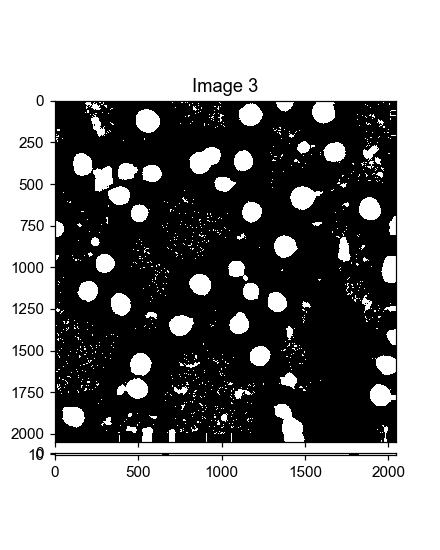

In [11]:
visual_tools.imshow_mark_3d_v2([polyt_im, waterIm, waterMask])

<IPython.core.display.Javascript object>


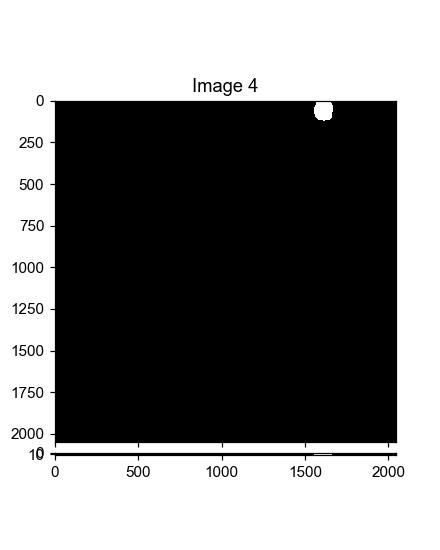

In [13]:
visual_tools.imshow_mark_3d_v2([polyt_im, corr_labels3d, new_labels, corr_labels3d==1])